In [16]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR='D:/dvc/train/train'
TEST_DIR='D:/dvc/test/test'
IMAGE_SIZE=50
LR=1e-3
MODEL_NAME='dogsvscats-{}-{}.model'.format(LR,'2conv-basic-video')

In [17]:
def lable_img(img):
  word_label=img.split('.')[-3]
  if word_label=='cat': return [1,0]
  elif word_label=='dog':return [0,1]

In [18]:
def create_train_data():
  training_data=[]
  for img in tqdm(os.listdir(TRAIN_DIR)):
    label=lable_img(img)
    path=os.path.join(TRAIN_DIR,img)
    img=cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMAGE_SIZE,IMAGE_SIZE))
    training_data.append([np.array(img),np.array(label)])
  shuffle(training_data)
  np.save('train_data.npy',training_data)
  return training_data

In [19]:
def process_test_data():
  testing_data=[]
  for img in tqdm(os.listdir(TEST_DIR)):
    path=os.path.join(TEST_DIR,img)
    img_num=img.split('.')[0]
    img=cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMAGE_SIZE,IMAGE_SIZE))
    testing_data.append([np.array(img),img_num])
  np.save('test_data.npy',testing_data)
  return testing_data

In [20]:
train_data=create_train_data()

100%|██████████| 25000/25000 [01:37<00:00, 256.20it/s]


In [27]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()




convnet = input_data(shape=[None, IMAGE_SIZE, IMAGE_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='logdir')


In [28]:
if os.path.exists('().meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [29]:
train=train_data[:-500]
test=train_data[-500:]

In [30]:
X=np.array([i[0] for i in train]).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
Y=[i[1] for i in train]
test_x=np.array([i[0] for i in test]).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
test_y=[i[1] for i in test]

In [31]:

model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 0.55776 | time: 44.360s
| Adam | epoch: 003 | loss: 0.55776 - acc: 0.7148 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.56720 | time: 45.477s
| Adam | epoch: 003 | loss: 0.56720 - acc: 0.7090 | val_loss: 0.66602 - val_acc: 0.6500 -- iter: 24500/24500
--


In [32]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\Dasam\Cat vs Dog\dogsvscats-0.001-2conv-basic-video.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 12500/12500 [00:11<00:00, 1130.09it/s]


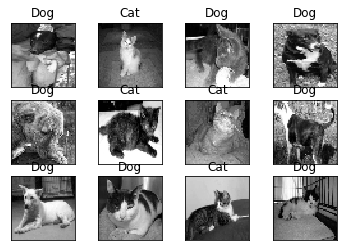

In [33]:
import matplotlib.pyplot as plt
test_data = process_test_data()
fig=plt.figure()
for num, data in enumerate(test_data[:12]):
    img_num=data[1]
    img_data=data[0]
    y=fig.add_subplot(3,4,num+1)
    orig=img_data
    data=img_data.reshape(IMAGE_SIZE,IMAGE_SIZE,1)
    model_out=model.predict([data])[0]
    if np.argmax(model_out)==1: str_label='Dog'
    else: str_label='Cat'
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()